# Проект e-commerce

## Содержание:

[Предварительный анализ](#Предварительное-исследование-данных:) 
1. [Пользователи, совершившие покупку только один раз](#1.-Количество-пользователей,-совершивших-покупку-только-один-раз) 

2. [Среднее количество недоставленных заказов за месяц с детализацией по причинам](#2.-Сколько-заказов-в-месяц-в-среднем-не-доставляется-по-разным-причинам-(детализация-по-причинам))

3. [Дни недели самых активных продаж по каждому товару.](#3.-В-какой-день-недели-каждый-вид-товара-чаще-всего-покупается.)

4. [Среднее количество покупок в неделю (по месяцам) у каждого из пользователей.](#4.-Сколько-у-каждого-из-пользователей-в-среднем-покупок-в-неделю-(по-месяцам))

5. [Когортный анализ пользователей с января по декабрь. Определение когорты с самым высоким retention на 3й месяц.](#5.-Когортный-анализ-пользователей-с-января-по-декабрь.-Определение-когорты-с-самым-высоким-retention-на-3й-месяц)

6. [RFM-сегментация пользователей](#6.-RFM-сегментация-пользователей,-для-качественной-оценки-аудитории)

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

**Загрузка датасетов** 

`customers` - таблица с уникальными идентификаторами пользователей

* customer_id — позаказный идентификатор пользователя

* customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

* customer_zip_code_prefix —  почтовый индекс пользователя

* customer_city —  город доставки пользователя

* customer_state —  штат доставки пользователя

In [2]:
customers = pd.read_csv('https://raw.githubusercontent.com/GerelMN/portfolio_projects/main/e-commerce/olist_customers_dataset.csv')
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


`orders` - таблица заказов

* order_id —  уникальный идентификатор заказа (номер чека)
* customer_id —  позаказный идентификатор пользователя
* order_status —  статус заказа
* order_purchase_timestamp —  время создания заказа
* order_approved_at —  время подтверждения оплаты заказа
* order_delivered_carrier_date —  время передачи заказа в логистическую службу
* order_delivered_customer_date —  время доставки заказа
* order_estimated_delivery_date —  обещанная дата доставки

In [3]:
orders = pd.read_csv('https://raw.githubusercontent.com/GerelMN/portfolio_projects/main/e-commerce/olist_orders_dataset.csv', parse_dates=['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'])
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


`items` - товарные позиции, входящие в заказы

* order_id —  уникальный идентификатор заказа (номер чека)
* order_item_id —  идентификатор товара внутри одного заказа
* product_id —  ид товара (аналог штрихкода)
* seller_id — ид производителя товара
* shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
* price —  цена за единицу товара
* freight_value —  вес товара

In [4]:
items = pd.read_csv('https://raw.githubusercontent.com/GerelMN/portfolio_projects/main/e-commerce/olist_order_items_dataset.csv')
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


# Предварительное исследование данных:

**Проверка на пропущенные значения и уникальность**

In [5]:
customers.info()
print('\033[1m' + '\n', customers['customer_unique_id'].nunique(), 'уникальных пользователей в таб. "customers"')
print(customers['customer_id'].nunique(), 'уникальных позаказных идентификаторов пользователей в таб."customers"' + '\033[0m')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB

 96096 уникальных пользователей в таб. "customers"
99441 уникальных позаказных идентификаторов пользователей в таб."customers"


In [6]:
items.info()
print('\033[1m' + '\n', items['order_id'].nunique(), 'уникальных идентификаторов заказов в таб. "items"')
print(items['product_id'].nunique(), 'уникальных идентификаторов товаров в таб. "items"')
print(items['seller_id'].nunique(), 'уникальных идентификаторов продавцов в таб. "items"' + '\033[0m')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB

 98666 уникальных идентификаторов заказов в таб. "items"
32951 уникальных идентификаторов товаров в таб. "items"
3095 уникальных идентификаторов продавцов в таб. "items"


In [7]:
orders.info()
print('\033[1m' + '\n', orders['customer_id'].nunique(), 'уникальных позаказных идентификаторов пользователей в таб. "orders"')
print(orders['order_id'].nunique(), 'уникальных идентификаторов заказов в таб."orders"' + '\033[0m')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB

 99441 уникальных позаказных идентификаторов пользователей в таб. "orders"
99441 уникальных идентификаторов заказов в таб."orders"


Пропущенные значения есть только в таблице заказов `orders` по трем колонкам с датами

In [8]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

**Сопоставим данные о датах, имеющие пропущенные значения со статусами заказов**

In [9]:
orders['order_status'].value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [10]:
# Отберем пропущенные значения по колонкам с датами
# Переведем булевые значения в целочисленный тип
missing_dates = orders[['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']].isna().astype(int)
# Объединим статусы заказов с даннными о пропущенных занчениях по колонкам дат
status_missing_date = pd.concat([orders[['order_id', 'order_status']], missing_dates], axis=1)

Посчитаем количество пропущеных значений в колонках с датами в разрезе статусов заказов

In [11]:
status_missing_date.groupby('order_status', as_index=False)['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date'].sum()

,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date
0,approved,0,2,2
1,canceled,141,550,619
2,created,5,5,5
3,delivered,14,2,8
4,invoiced,0,314,314
5,processing,0,301,301
6,shipped,0,0,1107
7,unavailable,0,609,609


**Сравним количество уникальных идентификаторов в трех таблицах:**
 1. Количество уникальных customer_unique_id меньше уникальных позаказных customer_id в таблице `customers`, значит есть покупатели сделавшие больше одного заказа 
 2. Количество позаказных customer_id в таблице `customers` совпадает с количеством уникальных order_id в таблице `orders`, эти две колонки равноценны по предствляемой ими информации. Общее количество зарегистрированных заказов - 99441 
 3. Количество уникальных order_id в таблице `items` меньше чем в таблице `orders` на 775 заказов. 
 4. Количество уникальных заказов превышает количество уникальных номеров товаров и продавцов в таблице `items`, следовательно есть товары, которые были проданы множетсво раз и есть продавцы совершившие более одной продажи   

Проверка заказов, которые есть в таблице `orders` ,но отсутствуют в таблице `items`

In [12]:
# В orders создадим колонку-идентификатор наличия заказа в таблице items
orders['in_items'] = (orders.order_id.isin(items.order_id).astype(int))
# отфильтруем 775 заказов, которых нет
not_in_items = orders.query('in_items==0')
# проверка
len(not_in_items)

775

In [13]:
# статусы заказов, отсутствующих в items
not_in_items['order_status'].value_counts()

unavailable    603
canceled       164
created          5
invoiced         2
shipped          1
Name: order_status, dtype: int64

В таблице `items` отсутствуют 603 из общих 609 заказов со статусом `"unavailable"`, из чего можно предположить, что статус 
`"unavailable"` присваивается тем заказам, товары в которых отсутсвуют в ассортименте магазина на данный момент (возможно нет соответствующего `produсt_id` в таблице `items`, поэтому `order_id` в `items` не попал, а в `orders` такому заказу был  присвоен статус `"unavailable"`)

In [14]:
# Проверим оставшиеся 6 заказов со статусом "unavailable"
orders.query('order_status=="unavailable" and in_items==1')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,in_items
33157,dc18a044b56ed174037ca164cdf2e921,4a06381959b6670756de02e07b83815f,unavailable,2016-10-05 14:16:28,2016-10-06 15:56:49,NaT,NaT,2016-11-29,1
50731,4dd47e84e6b8ff4a63d0b8425e6d788e,96bbcbc8372c86da857d842dfda6bd72,unavailable,2016-10-06 23:49:18,2016-10-07 01:09:08,NaT,NaT,2016-11-24,1
60805,3c3ca08854ca922fe8e9cedfd6841c8a,88c36fbd3df96094f90f0315e1d2dd90,unavailable,2016-10-08 12:13:38,2016-10-08 13:21:35,NaT,NaT,2016-11-30,1
62504,54bb06e1ca86bd99ee2a8d6288bf4ede,98bfbf477ed9f40a0264f5e527a446be,unavailable,2016-10-06 13:38:39,2016-10-06 14:22:19,NaT,NaT,2016-12-12,1
79275,1a47da1d66c70489c8e35fe2b5433ab7,3d8e326c3cef3a9bba7ca121baac5fc3,unavailable,2016-10-07 18:16:31,2016-10-07 18:53:48,NaT,NaT,2016-12-07,1
83645,2fd1c83dd4714cf3cf796fffb6c8de62,7f51c513004ef3f35e834c142f286778,unavailable,2016-10-05 17:21:29,2016-10-06 15:55:40,NaT,NaT,2016-11-29,1


Оставшиеся 6 заказов со статусом `"unavailable"` попали в табл. `items`, но не были собраны и переданы продавцом на склад службы логистики. Возможно статус `"unavailable"` также может быть присвоен заказу, если он не был доставлен продавцом вовремя на склад службы логистики и является недостуным для дальнейшей доставки покупателю. Нарушен срок `shipping_limit_date`. 

**Временные рамки** полученных данных приблизительно 2 года

In [15]:
last_time = orders[['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']].max()\
    .to_frame()\
    .rename(columns={0: 'max_time'})
first_time = orders[['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']].min()\
    .to_frame()\
    .rename(columns={0: 'min_time'})
pd.concat([first_time, last_time], axis=1)

,min_time,max_time
order_purchase_timestamp,2016-09-04 21:15:19,2018-10-17 17:30:18
order_approved_at,2016-09-15 12:16:38,2018-09-03 17:40:06
order_delivered_carrier_date,2016-10-08 10:34:01,2018-09-11 19:48:28
order_delivered_customer_date,2016-10-11 13:46:32,2018-10-17 13:22:46
order_estimated_delivery_date,2016-09-30 00:00:00,2018-11-12 00:00:00


### С помощью статусов заказов и зафиксированного времени определим структуру движения заказа в маркетплейсе от оформления заказа покупателем на сайте до доставки по адресу.  

**Предполагаемая структура движения заказа**
1. Покупатель приступает к созданию заказа, фиксируется время создания (`order_purchase_timestamp`), присваеивается статус `"created"`. Но покупатель может так и не закончить формирование корзины и не получить счет на оплату. В этом случае все остальные даты остаются не заполненными, статус остается `"created"` (Всего 5 заказов с таким статусом, все ключевые даты не заполнены) 
2. Покупатель сформировал корзину и получил счет на оплату, заказу присваивается статус `"invoiced"`.
3. Покупатель оплатил счет, время оплаты фиксируется (`order_approved_at`), статус заказа `"approved"` (2 заказа с этим статусом оплачены, значит покупатель по ним сначала получил счет, поэтому статус approved идет после статуса `invoiced`). Рассчитывается приблизительное время доставки покупателю (`order_estimated_delivery_date`) 
4. После полученной информации об оплате продавец приступает к сборке заказа, присваивается статус `"processing"`. Время на сборку заказа для продавца ограничено (`shipping_limit_date`)  
5. Собранный заказ продавец доставляет на склад службы логистики, время доставки фиксируется (`order_delivered_carrier_date`)  
5. Заказ отгружен со склада службы логистики и находится в пути к адресу покупателя, статус `"shipped"`
6. Заказ доставлен покупателю, время доставки зафиксировано (`order_delivered_customer_date`), заказу присвоен статус `"delivered"`
7. Статус `"unavaliable"` возможно присваивается в случае отсутствия товара в ассортименте продавца или в случае если заказ не был вовремя доставлен на склад службы логистики. В обоих вариантах у заказа с таким статусом не должно быть времени регистрации на складе логистики и времени доставки покупателю. 
8. Статус `"canceled"` присвоен заказам, которые были отменены по инициативе покупателя. Покупатель может передумать делать покупку и отменить заказ на любом этапе, как до оплаты так и после. В случае, если покупатель получил бракованный товар, он отменяет покупку уже после получения (6 заказов-статус "canceled", дата order_delivered_customer_date зафиксирована)  

# 1. Количество пользователей, совершивших покупку только один раз

`Покупкой` будем считать заказ, статус которого не равен `"canceled"` или `"unavailable"`. Т.е., чтобы заказ считался совершенным покупателем, он должен быть доступным и не отменененным покупателем. 

In [16]:
# исключили отмененные и недоступные заказы
confirmed_orders = pd.DataFrame(orders.query('order_status not in ["canceled", "unavailable"]'))
# Проверка:625 отменены и 609 недоступны->625+609=1234
# 1234 заказа должны быть исключены
len(orders) - len(confirmed_orders)

1234

In [17]:
# Проверка: заказов со статусом canceled и unavailable датафрейме нет
confirmed_orders['order_status'].value_counts()

delivered     96478
shipped        1107
invoiced        314
processing      301
created           5
approved          2
Name: order_status, dtype: int64

In [18]:
# Присоединяем уникальные id покупателей из датафрейма customers
order_customer_data = confirmed_orders.merge(customers[['customer_unique_id', 'customer_id']], on='customer_id', how='left')
order_customer_data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,in_items,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1,72632f0f9dd73dfee390c9b22eb56dd6


In [19]:
# Сгруппировали заказы по уникальным покупателям
sum_of_orders = order_customer_data.groupby('customer_unique_id', as_index=False)\
    .agg({'order_id': 'count'})\
    .rename(columns={'order_id': 'sum_of_orders'})\
    .sort_values(by='sum_of_orders', ascending=False)
sum_of_orders

,customer_unique_id,sum_of_orders
52358,8d50f5eadf50201ccdcedfb9e2ac8455,16
23201,3e43e6105506432c953e165fb2acf44c,9
37374,6469f99c1f9dfae7733b25662e7f1782,7
10235,1b6c7548a2a1f9037c1fd3ddfed95f33,7
75211,ca77025e7201e3b30c44b472ff346268,7
...,...,...
32122,56509f7bc43892a0da09ee14f50a6f84,1
32121,564feb90710b4f84399f931fa97ea704,1
32120,564fb2956ed34f0a78c1cc37d731f3d9,1
32119,564f89ca1f5371992bf1fb87a0331ac3,1


Из полученных данных видно, что есть покупатели, которые совершали покупки более одного раза и покупатели, которые совершали покупку только один раз

In [20]:
# Количество покупателей совершивших только 1 покупку
print('\033[1m' + 'Сколько у нас пользователей, которые совершили покупку только один раз?')
print(sum_of_orders.query('sum_of_orders==1')['customer_unique_id'].count(), 'пользователь совершил покупку на сайте только один раз.' + '\033[0m')

Сколько у нас пользователей, которые совершили покупку только один раз?
92102 пользователь совершил покупку на сайте только один раз.


**Вывод:**  Из 96096 пользователей 95,84% (92102) за 2 года сделали только один заказ 

# 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (детализация по причинам)

**2.1. Определим недоставленные заказы**

In [21]:
# Пропущенные значения в дадасете совершенных заказов
confirmed_orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  19
order_delivered_carrier_date      624
order_delivered_customer_date    1737
order_estimated_delivery_date       0
in_items                            0
dtype: int64

Проверка пропущенных значений среди совершенных покупателем покупок показывает, что есть заказы без даты доставки покупателю и даты доставки на склад.  
`Недоставленными заказами` будем считать совершенные покупателем заказы без зафиксированного времени доставки. При этом подразумевается, что все недоставленные на склад логистики заказы, не должны быть доставлены покупателю, т.е. из 1737 недоставленных покупателю заказа 624 должны быть не доставлены на склад логистики.

In [22]:
# Заказы без времени доставки покупателю. Проверка пропущенных занчений.
not_delivered = pd.DataFrame(confirmed_orders[confirmed_orders['order_delivered_customer_date'].isna()])
not_delivered.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                   5
order_delivered_carrier_date      623
order_delivered_customer_date    1737
order_estimated_delivery_date       0
in_items                            0
dtype: int64

В сравнении пропущенных занчений видно, что один заказ не был доставлен на склад, но был доставлен покупателю.  
Из 1737 недоставленных покупателю заказа 623 не доставлены на склад логистики.

In [23]:
# Заказы, без времени доставки на склад логистики,
# но со временем доставки покупателю.
not_logistic = confirmed_orders[confirmed_orders['order_delivered_carrier_date'].isna()]
not_logistic[not_logistic['order_delivered_customer_date'].notna()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,in_items
73222,2aa91108853cecb43c84a5dc5b277475,afeb16c7f46396c0ed54acb45ccaaa40,delivered,2017-09-29 08:52:58,2017-09-29 09:07:16,NaT,2017-11-20 19:44:47,2017-11-14,1


Полученный заказ оплачен, имеет статус `"delivered"`. Возможно продавец доставил заказ покупателю самостоятельно, или по техническим причинам время доставки на склад зафиксировано не было.

**2.2. Определим возможные причины, по которым заказы не были доставлены покупателю**

Выделим предполагаемые причины недосатвки заказов, рассмотрев недоставленные заказы в разрезе статусов

In [24]:
missing = not_delivered[['order_delivered_carrier_date', 'order_delivered_customer_date']].isna().astype(int)
# Объединим статусы заказов с даннными о пропущенных занчениях по колонкам дат
not_delivered_status = pd.concat([not_delivered[['order_id', 'order_status']], missing], axis=1)
# Посчитаем количество пропущщеных занчений в колонках с датами в разрезе статусов заказов
not_delivered_status.groupby('order_status', as_index=False)['order_delivered_carrier_date', 'order_delivered_customer_date'].sum()

,order_status,order_delivered_carrier_date,order_delivered_customer_date
0,approved,2,2
1,created,5,5
2,delivered,1,8
3,invoiced,314,314
4,processing,301,301
5,shipped,0,1107


In [25]:
# 8 заказов состатусом "доставлено", но без времени доставки
not_delivered.query('order_status=="delivered"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,in_items
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,ec05a6d8558c6455f0cbbd8a420ad34f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaT,2017-12-18,1
20618,f5dd62b788049ad9fc0526e3ad11a097,5e89028e024b381dc84a13a3570decb4,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaT,2018-07-16,1
43834,2ebdfc4f15f23b91474edf87475f108e,29f0540231702fda0cfdee0a310f11aa,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,NaT,2018-07-30,1
79263,e69f75a717d64fc5ecdfae42b2e8e086,cfda40ca8dd0a5d486a9635b611b398a,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,NaT,2018-07-30,1
82868,0d3268bad9b086af767785e3f0fc0133,4f1d63d35fb7c8999853b2699f5c7649,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,NaT,2018-07-24,1
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23,1
97647,ab7c89dc1bf4a1ead9d6ec1ec8968a84,dd1b84a7286eb4524d52af4256c0ba24,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,NaT,2018-06-26,1
98038,20edc82cf5400ce95e1afacc25798b31,28c37425f1127d887d7337f284080a0f,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,NaT,2018-07-19,1


Недоставленные 1737 заказ можно примерно разделить на 3 группы: 
* 623 заказов не было доставлено продавцом на склад логистики для дальнейшей доставки покупателю (нет времени доставки на склад), 
* 1107 заказов служба логистики не доставила покупателям(есть время доставки на склад логистики,нет времени доставки покупателю, статус "shipped"), 
* 7 заказов со статусом "delivered" были доставлены на склад, но не имеют времени доставки покупателю. Возможно  техническая ошибка: неверно проставлен статус заказа и заказы не были доставлены, либо заказы доставлены покупателю, статус указан верно, но по техническим причинам время не было зафиксировано. 

При этом 623 заказа, недоставленных продавцом на склад логистики также можно разбить на группы: 
* approved(2)+invoiced(314)=316 заказов были оплачены, но сборка так и не началась(processing), возможно информация об оплате не поступила продавцу, поэтому продавец не приступил к сборке заказа.
* processing(301) заказ не был собран продавцом вовремя, возможно товара нет в наличии у продавца
* delivered(1)-возможно техническая ошибка, неверно указан статус, нет времени доставки на склад и покупателю

In [26]:
def get_reason(feature):
    '''Функция для определения причины недоставки заказа'''
    if feature == 'approved' or feature == 'invoiced':
        return "Нет на складе логистики, возможно информация об оплате не получена продавцом"
    elif feature == 'unavailable' or feature == 'processing':
        return 'Нет на складе логистики. Продавец не предоставил заказ вовремя, возможно товара нет в наличии'
    elif feature == 'shipped':
        return 'Проблема службы логистики. Заказ отгружен со склада, недоставлен до адреса покупателя вовремя'
    else:
        return 'Возможно техническая ошибка, требутся провести более детальное исследование'

In [27]:
# Создали колонку с указанием причины недоставки заказа
not_delivered['reason'] = not_delivered['order_status'].apply(get_reason)

In [28]:
# общее количество недоставленных заказов с детализацией по причинам за весь период
not_delivered['reason'].value_counts()

Проблема службы логистики. Заказ отгружен со склада, недоставлен до адреса покупателя вовремя    1107
Нет на складе логистики, возможно информация об оплате не получена продавцом                      316
Нет на складе логистики. Продавец не предоставил заказ вовремя, возможно товара нет в наличии     301
Возможно техническая ошибка, требутся провести более детальное исследование                        13
Name: reason, dtype: int64

**2.3. Определим сколько заказов в месяц в среднем не доставляется по разным причинам**

In [29]:
# Колонку с предполагаемой датой доставки переведем в тип datetime
# введем колонки с предполагаемым месяцем и годом доставки
not_delivered['order_estimated_delivery_date'] = pd.to_datetime(not_delivered['order_estimated_delivery_date'])
not_delivered['order_estimated_delivery_month'] = not_delivered['order_estimated_delivery_date'].dt.month
not_delivered['order_estimated_delivery_year'] = not_delivered['order_estimated_delivery_date'].dt.year

In [30]:
# Проверка: order_estimated_delivery_date изменился тип данных на datetime
# и добавлены 2 колонки с предполагаемыми годом и месяцем доставки, тип данных int
not_delivered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1737 entries, 6 to 99313
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   order_id                        1737 non-null   object        
 1   customer_id                     1737 non-null   object        
 2   order_status                    1737 non-null   object        
 3   order_purchase_timestamp        1737 non-null   datetime64[ns]
 4   order_approved_at               1732 non-null   datetime64[ns]
 5   order_delivered_carrier_date    1114 non-null   datetime64[ns]
 6   order_delivered_customer_date   0 non-null      datetime64[ns]
 7   order_estimated_delivery_date   1737 non-null   datetime64[ns]
 8   in_items                        1737 non-null   int32         
 9   reason                          1737 non-null   object        
 10  order_estimated_delivery_month  1737 non-null   int64         
 11  ord

In [31]:
# Количество недоставленных заказов с детализацией по причинам по месяцам
monthly_reasons = not_delivered.groupby(['order_estimated_delivery_month', 'reason'], as_index=False)\
    .agg({'order_id': 'count'})\
    .rename(columns={'order_id': 'not_delivered_orders'})

In [32]:
# Сколько заказов в месяц в среднем не было доставлено по разным причинам по всем предоставленным данным
mean_monthly = monthly_reasons.groupby('reason', as_index=False)['not_delivered_orders'].mean()\
    .rename(columns={'not_delivered_orders': 'mean_not_delivered_orders'})
print('\033[1m'+'Сколько заказов в месяц в среднем не доставлено по разным причинам (по всем данным)' + '\033[0m')
pd.set_option('display.max_colwidth', 0)
mean_monthly

Сколько заказов в месяц в среднем не доставлено по разным причинам (по всем данным)


,reason,mean_not_delivered_orders
0,"Возможно техническая ошибка, требутся провести более детальное исследование",2.600000
1,"Нет на складе логистики, возможно информация об оплате не получена продавцом",26.333333
2,"Нет на складе логистики. Продавец не предоставил заказ вовремя, возможно товара нет в наличии",25.083333
3,"Проблема службы логистики. Заказ отгружен со склада, недоставлен до адреса покупателя вовремя",92.250000


Поскольку в 2016 и 2018 гг данные представлены за неполный год, можно взять данные для ответа на вопрос за полный 2017 год.

In [33]:
not_delivered_2017 = not_delivered.query('order_estimated_delivery_year==2017')

In [34]:
monthly_reasons_2017 = not_delivered_2017.groupby(['order_estimated_delivery_month', 'reason'], as_index=False)\
    .agg({'order_id': 'count'})\
    .rename(columns={'order_id': 'not_delivered_orders'})
mean_monthly_2017 = monthly_reasons_2017.groupby('reason', as_index=False)['not_delivered_orders'].mean()\
    .rename(columns={'not_delivered_orders': 'mean_not_delivered_orders_2017'})
print('\033[1m'+'Сколько заказов в месяц в среднем не доставлено по разным причинам за 2017 год' + '\033[0m')
mean_monthly_2017

Сколько заказов в месяц в среднем не доставлено по разным причинам за 2017 год


,reason,mean_not_delivered_orders_2017
0,"Возможно техническая ошибка, требутся провести более детальное исследование",2.000000
1,"Нет на складе логистики, возможно информация об оплате не получена продавцом",15.363636
2,"Нет на складе логистики. Продавец не предоставил заказ вовремя, возможно товара нет в наличии",19.000000
3,"Проблема службы логистики. Заказ отгружен со склада, недоставлен до адреса покупателя вовремя",44.272727


# 3. В какой день недели каждый вид товара чаще всего покупается.

In [35]:
# Создали колонку с названием дня недели
confirmed_orders['dayweek_purchase'] = confirmed_orders['order_approved_at'].dt.day_name()

In [36]:
# присоединили к items дни недели покупки
item_data = items.merge(confirmed_orders[['dayweek_purchase', 'order_id']], on='order_id', how='left')
item_data.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,dayweek_purchase
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,Wednesday
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,Wednesday
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,Sunday
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,Wednesday
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,Saturday


In [37]:
# Отфильтровали данные, у которых не заполнился день недели
not_day = item_data[item_data['dayweek_purchase'].isna()]
not_day.shape

(564, 8)

У 564 заказов не заполнися день покупки. Возможно это отмененные заказы. Для проверки к таблице с незаполненными днями присоединяем информацию об оплате и статусе

In [38]:
not_day_status = not_day.merge(orders[['order_status', 'order_approved_at', 'order_id']], on='order_id', how='left')
not_day_status.order_status.value_counts()

canceled       542
delivered      15 
unavailable    7  
Name: order_status, dtype: int64

In [39]:
not_day_status.isna().sum()

order_id               0  
order_item_id          0  
product_id             0  
seller_id              0  
shipping_limit_date    0  
price                  0  
freight_value          0  
dayweek_purchase       564
order_status           0  
order_approved_at      15 
dtype: int64

Из 564 заказов, у которых не указан день покупки:542 отменены, 15 не оплачены, 7 недоступны 

In [40]:
# Из данных о товарах удалим заказы без дня покупки
clean_items = item_data.dropna(subset=['dayweek_purchase'])
# Проверка: 564 отмененных и неоплаченных заказов удалены
len(item_data)-len(clean_items)

564

In [41]:
# По каждому товару посчитали по дням недели сколько раз он был куплен в этот день
day_item = clean_items.groupby('product_id')['dayweek_purchase'].value_counts()\
    .to_frame()\
    .rename(columns={'dayweek_purchase': 'amount_of_orders'})\
    .reset_index()
day_item.head()

,product_id,dayweek_purchase,amount_of_orders
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Friday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1


In [42]:
# По каждому товару определили день недели, в который он покупался чаще всего
day_item['max_day'] = day_item.groupby('product_id')['amount_of_orders'].transform('max') == day_item['amount_of_orders']

In [43]:
# Выбрали данные где количество сделанных покупок по каждому товару равно максимальному
max_day_item = day_item.query('max_day==True')

Проверка: Например выберем данные по одному товару, который был куплен во вторник 3 раза и по одному разу в четверг и пятницу.
Вторник помечен как день с максимальным количеством заказов на данный товар

In [44]:
day_item.query('product_id=="fffdb2d0ec8d6a61f0a0a0db3f25b441"')

,product_id,dayweek_purchase,amount_of_orders,max_day
60789,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,3,True
60790,fffdb2d0ec8d6a61f0a0a0db3f25b441,Friday,1,False
60791,fffdb2d0ec8d6a61f0a0a0db3f25b441,Thursday,1,False


В отфильтрованных данных `max_day_item` отражен день, только с максимальным количеством заказов

In [45]:
max_day_item.query('product_id=="fffdb2d0ec8d6a61f0a0a0db3f25b441"')

,product_id,dayweek_purchase,amount_of_orders,max_day
60789,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,3,True


В случае, если бы у каждого продукта был бы один явный максимальный день, то количество уникальных `product_id` равнялось бы количеству строк таблицы с днем максимальных продаж для каждого продукта `max_day_item`

In [46]:
print(clean_items['product_id'].nunique(), 'количество уникальных продуктов в базе')
print(len(max_day_item), 'количество строк таблицы с днем максимальных продаж для каждого продукта')

32726 количество уникальных продуктов в базе
42345 количество строк таблицы с днем максимальных продаж для каждого продукта


Поскольку количество строк `max_day_item` больше чем уникальных продуктов, значит у каких-то продуктов по некоторым дням одинаковое количество продаж. В полученной таблице некоторые id продуктов повторяются до шести раз.

In [47]:
max_day_item['product_id'].value_counts().to_frame()\
    .query('product_id>1')\
    .head(10)

,product_id
6e40985ec667ded54668d2b70a7aa0a2,6
8a8d870b168dfa470a5f28efab92145d,6
162e010af9fe224d35fd8496a273fb02,6
8920f1824cd68512eb6fb0b0f41004bf,6
1a7d1ce0dddfef9f6f2ed280798fd9bb,6
80d3aeff2ab6c9d795010c029dbd5ddd,6
33ab88b1e48538d846cd26ea55d34108,6
79d2c1de4aaac73cf031b5e1f03a68aa,6
007c63ae4b346920756b5adcad8095de,6
7aeaa8f3e592e380c420e8910a717255,6


Для примера возьмем продукт, который повторяется в `max_day_item` больше одного раза. 6 дней: Вт,Ср, Чт, Пт, Сб, Вс, этот продукт продавался по одному разу, выделить один максимальный день недели невозможно

In [48]:
max_day_item.query('product_id=="007c63ae4b346920756b5adcad8095de"')

,product_id,dayweek_purchase,amount_of_orders,max_day
84,007c63ae4b346920756b5adcad8095de,Friday,1,True
85,007c63ae4b346920756b5adcad8095de,Saturday,1,True
86,007c63ae4b346920756b5adcad8095de,Sunday,1,True
87,007c63ae4b346920756b5adcad8095de,Thursday,1,True
88,007c63ae4b346920756b5adcad8095de,Tuesday,1,True
89,007c63ae4b346920756b5adcad8095de,Wednesday,1,True


Для товаров, у которых количество продаж по нескольким дням недели равно максимальному, дни недели выведем списком

In [49]:
best_days = max_day_item.groupby(['product_id', 'amount_of_orders'], as_index=False).agg({'dayweek_purchase': pd.Series.to_list})
best_days['dayweek_purchase'] = best_days.dayweek_purchase.apply(lambda x: ', '.join(x))
best_days.head()

,product_id,amount_of_orders,dayweek_purchase
0,00066f42aeeb9f3007548bb9d3f33c38,1,Sunday
1,00088930e925c41fd95ebfe695fd2655,1,Tuesday
2,0009406fd7479715e4bef61dd91f2462,1,Friday
3,000b8f95fcb9e0096488278317764d19,1,"Friday, Wednesday"
4,000d9be29b5207b54e86aa1b1ac54872,1,Tuesday


In [50]:
# Проверка товара с одной продажей 6 дней
best_days.query('product_id=="007c63ae4b346920756b5adcad8095de"')

,product_id,amount_of_orders,dayweek_purchase
50,007c63ae4b346920756b5adcad8095de,1,"Friday, Saturday, Sunday, Thursday, Tuesday, Wednesday"


In [51]:
# Проверка: количество уникальных id товаров совпадает с количеством строк полученной таблицы
print(clean_items['product_id'].nunique(), 'количество уникальных продуктов в базе')
print(len(best_days), 'количество строк таблицы с днем максимальных продаж для каждого продукта')

32726 количество уникальных продуктов в базе
32726 количество строк таблицы с днем максимальных продаж для каждого продукта


In [52]:
print('\033[1m' + 'Дни недели максимальных продаж по каждому товару' + '\033[0m')
print('\033[4m' + 'Учесть, что есть товары, с одинаковым количеством проданных товаров по некоторым дням' + '\033[0m')
best_days.sort_values(by='amount_of_orders', ascending=False).head()

Дни недели максимальных продаж по каждому товару
Учесть, что есть товары, с одинаковым количеством проданных товаров по некоторым дням


,product_id,amount_of_orders,dayweek_purchase
21957,aca2eb7d00ea1a7b8ebd4e68314663af,119,Tuesday
10787,53b36df67ebb7c41585e8d54d6772e08,105,Tuesday
8553,422879e10f46682990de24d770e7f83d,89,Tuesday
19597,99a4788cb24856965c36a24e339b6058,82,Tuesday
7032,368c6c730842d78016ad823897a372db,80,Thursday


# 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)

Для того чтобы посчитать для каждого пользователя по месяцам среднее количество покупок в неделю, нужно по каждому пользователю общее количество покупок за месяц поделить на количество недель в месяце

In [53]:
# Дату оплаты переведем в формат datetime
order_customer_data['order_approved_at'] = pd.to_datetime(order_customer_data['order_approved_at'])
# выделим месяц и год в отдельные колонки
order_customer_data['month_of_purchases'] = order_customer_data['order_approved_at'].dt.month
order_customer_data['year_of_purchases'] = order_customer_data['order_approved_at'].dt.year

In [54]:
order_customer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98207 entries, 0 to 98206
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       98207 non-null  object        
 1   customer_id                    98207 non-null  object        
 2   order_status                   98207 non-null  object        
 3   order_purchase_timestamp       98207 non-null  datetime64[ns]
 4   order_approved_at              98188 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97583 non-null  datetime64[ns]
 6   order_delivered_customer_date  96470 non-null  datetime64[ns]
 7   order_estimated_delivery_date  98207 non-null  datetime64[ns]
 8   in_items                       98207 non-null  int32         
 9   customer_unique_id             98207 non-null  object        
 10  month_of_purchases             98188 non-null  float64       
 11  year_of_purchas

Рассмотрим данные за год, для этого отберем 2017 год, так как за этот год есть информация за полный год

In [55]:
order_customer_2017 = order_customer_data.query('year_of_purchases==2017')
# количество сделанных покупок за каждый месяц по каждому покупателю
order_monthly = order_customer_2017.groupby(['customer_unique_id', 'month_of_purchases'], as_index=False)\
    .agg({'order_id': 'count'})\
    .rename(columns={'order_id': 'total_purchases'})
# Проверим по покупателю, который совершил более одной покупки
order_monthly.query('customer_unique_id=="8d50f5eadf50201ccdcedfb9e2ac8455"')

,customer_unique_id,month_of_purchases,total_purchases
23988,8d50f5eadf50201ccdcedfb9e2ac8455,5.0,1
23989,8d50f5eadf50201ccdcedfb9e2ac8455,6.0,1
23990,8d50f5eadf50201ccdcedfb9e2ac8455,7.0,2
23991,8d50f5eadf50201ccdcedfb9e2ac8455,8.0,1
23992,8d50f5eadf50201ccdcedfb9e2ac8455,9.0,1
23993,8d50f5eadf50201ccdcedfb9e2ac8455,10.0,2
23994,8d50f5eadf50201ccdcedfb9e2ac8455,11.0,1


Количество недель в месяце можно получить путем деления общего количества дней в месяце на 7 дней недели. Таким образом в месяцах с 30 днями будет 4.29 недели, в месяцах с 31 днем - 4.43 недели(4 недели и 3 дня), 28 дней - 4 недели. В феврале 2017 года 28 дней.

In [56]:
def get_weeks_amount(month):
    '''Функция для определения количества недель в месяце '''
    if month in [1, 3, 5, 7, 8, 10, 12]:
        return 4.43
    elif month in [4, 6, 9, 11]:
        return 4.29
    else:
        return 4

In [57]:
# проставим количество недель(weeks) в месяце
order_monthly['weeks'] = order_monthly['month_of_purchases'].apply(get_weeks_amount)
# расчитаем среднее количество покупок в неделю
order_monthly['weekly_mean'] = round(order_monthly['total_purchases']/order_monthly['weeks'], 2)

Для проверки рассмотрим данные по одному покупателю: 
* в `month of purchases` указаны все месяца, в которых покупатель совершал покупки, 
* в `total purchases` указано количество сделанных покупок в разрезе месяцев,
* в `weeks` количество недель в соответствующем месяце, 
* в `weekly_mean` среднее количество покупок в неделю по месяцам 

In [58]:
order_monthly.query('customer_unique_id=="8d50f5eadf50201ccdcedfb9e2ac8455"')

,customer_unique_id,month_of_purchases,total_purchases,weeks,weekly_mean
23988,8d50f5eadf50201ccdcedfb9e2ac8455,5.0,1,4.43,0.23
23989,8d50f5eadf50201ccdcedfb9e2ac8455,6.0,1,4.29,0.23
23990,8d50f5eadf50201ccdcedfb9e2ac8455,7.0,2,4.43,0.45
23991,8d50f5eadf50201ccdcedfb9e2ac8455,8.0,1,4.43,0.23
23992,8d50f5eadf50201ccdcedfb9e2ac8455,9.0,1,4.29,0.23
23993,8d50f5eadf50201ccdcedfb9e2ac8455,10.0,2,4.43,0.45
23994,8d50f5eadf50201ccdcedfb9e2ac8455,11.0,1,4.29,0.23


Рассмотрим покупателей с наивысшим показателем среднего количества покупок в неделю `weekly_mean`: один из покупателей в феврале 2017 совершал покупку каждую неделю, покупатель с показателем 1.35 в январе совершил покупку более одного раза в неделю. В остальных случаях покупатели не совершали покупку каждую неделю месяца.

In [59]:
order_monthly.sort_values(by='weekly_mean', ascending=False).head(10)

,customer_unique_id,month_of_purchases,total_purchases,weeks,weekly_mean
3274,12f5d6e1cbf93dafd9dcc19095df0b3d,1.0,6,4.43,1.35
27595,a239b8e2fbce33780f1f1912e2ee5275,2.0,4,4.00,1.00
30054,b08fab27d47a1eb6deda07bfd965ad43,9.0,4,4.29,0.93
6411,25a560b9a6006157838aab1bdbd68624,4.0,4,4.29,0.93
22493,83e7958a94bd7f74a9414d8782f87628,1.0,4,4.43,0.90
39451,e78838df9c44e102b6ac84cc5eea7d5c,2.0,3,4.00,0.75
2452,0e4cb268bd62da7db135af6349b4fc2a,11.0,3,4.29,0.70
36739,d7624d219b6ffad980e91412174db310,4.0,3,4.29,0.70
41904,f64ec6d8dd29940264cd0bbb5ecade8a,11.0,3,4.29,0.70
40293,ec7f1811826ab04a27a92197bc40c888,11.0,3,4.29,0.70


# 5. Когортный анализ пользователей с января по декабрь. Определение когорты с самым высоким retention на 3й месяц

Для проведения когортного анализа из данных с совершенными покупателями покупками выберем уникальных пользователей и даты регистрации сделанных ими заказов(отражают сколько раз пользователь возвращался и в какие даты)

In [60]:
customer_data = order_customer_data.loc[:, ['customer_unique_id', 'order_purchase_timestamp']]

In [61]:
customer_data['order_purchase_timestamp'] = pd.to_datetime(customer_data['order_purchase_timestamp'])
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98207 entries, 0 to 98206
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   customer_unique_id        98207 non-null  object        
 1   order_purchase_timestamp  98207 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 2.2+ MB


Для проведения анализа с января по декабрь выберем полный 2017 год

In [62]:
unique_customer_data = customer_data[customer_data['order_purchase_timestamp'].dt.year == 2017]

Преобразуем колонку с датой для дальнейшего определения когортной группы по месяцу

In [63]:
def get_month(x):
    return dt.datetime(x.year, x.month, 1)


unique_customer_data['order_purchase_timestamp'] = unique_customer_data['order_purchase_timestamp'].apply(get_month)

In [64]:
# По каждому пользователю определили месяц, когда он сделал заказ впервые
unique_customer_data['CohortMonth'] = unique_customer_data.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min')
unique_customer_data.head()

,customer_unique_id,order_purchase_timestamp,CohortMonth
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-01,2017-09-01
3,7c142cf63193a1473d2e66489a9ae977,2017-11-01,2017-11-01
5,80bb27c7c16e8f973207a5086ab329e2,2017-07-01,2017-07-01
6,36edbb3fb164b1f16485364b6fb04c73,2017-04-01,2017-04-01
7,932afa1e708222e5821dac9cd5db4cae,2017-05-01,2017-05-01


Определим разницу в месяцах между месяцем первого заказа и месяцами последующих заказов месяц возникновения проставим как первый. Написана общая формула для расчета с учетом разницы года, но в нашем случае разница года равна 0,т.к. данные отобраны за один год.

In [65]:
Year_Diff = (unique_customer_data['order_purchase_timestamp'].dt.year) - unique_customer_data['CohortMonth'].dt.year
Month_Diff = unique_customer_data['order_purchase_timestamp'].dt.month - unique_customer_data['CohortMonth'].dt.month
unique_customer_data['CohortIndex'] = Year_Diff * 12 + Month_Diff + 1
unique_customer_data.head()

,customer_unique_id,order_purchase_timestamp,CohortMonth,CohortIndex
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-01,2017-09-01,2
3,7c142cf63193a1473d2e66489a9ae977,2017-11-01,2017-11-01,1
5,80bb27c7c16e8f973207a5086ab329e2,2017-07-01,2017-07-01,1
6,36edbb3fb164b1f16485364b6fb04c73,2017-04-01,2017-04-01,1
7,932afa1e708222e5821dac9cd5db4cae,2017-05-01,2017-05-01,1


In [66]:
# Сгруппируем пользователей по месяцу первого заказа и
# разницами между первым и последующими заказами
grouping = unique_customer_data.groupby(['CohortMonth', 'CohortIndex'])['customer_unique_id'].nunique().to_frame()
grouping = grouping.reset_index()
grouping.head()

,CohortMonth,CohortIndex,customer_unique_id
0,2017-01-01,1,753
1,2017-01-01,2,3
2,2017-01-01,3,2
3,2017-01-01,4,1
4,2017-01-01,5,3


Преобразуем данные в сводную таблицу, где в индексе будут указаны когортные группы, а в колонках будут месяца прошедшие с месяца первого заказа(под индексом один-месяц возникновения когортной группы)

In [67]:
cohort_counts = grouping.pivot(index="CohortMonth", columns="CohortIndex", values="customer_unique_id")
retention = cohort_counts
retention

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,
2017-01-01,753.0,3.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,NaN,3.0,1.0
2017-02-01,1690.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,2.0,3.0,2.0,NaN
2017-03-01,2571.0,13.0,9.0,10.0,9.0,4.0,4.0,8.0,9.0,2.0,NaN,NaN
2017-04-01,2326.0,14.0,5.0,4.0,7.0,6.0,8.0,7.0,7.0,NaN,NaN,NaN
2017-05-01,3541.0,17.0,17.0,14.0,11.0,12.0,15.0,5.0,NaN,NaN,NaN,NaN
2017-06-01,3102.0,14.0,11.0,12.0,8.0,12.0,11.0,NaN,NaN,NaN,NaN,NaN
2017-07-01,3823.0,20.0,13.0,9.0,11.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01,4130.0,28.0,14.0,11.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-01,4076.0,28.0,22.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
# Отформатируем индекс для отображения на графике в виде месяца и года
retention.index = retention.index.strftime('%B %Y')

<AxesSubplot:xlabel='CohortIndex', ylabel='CohortMonth'>

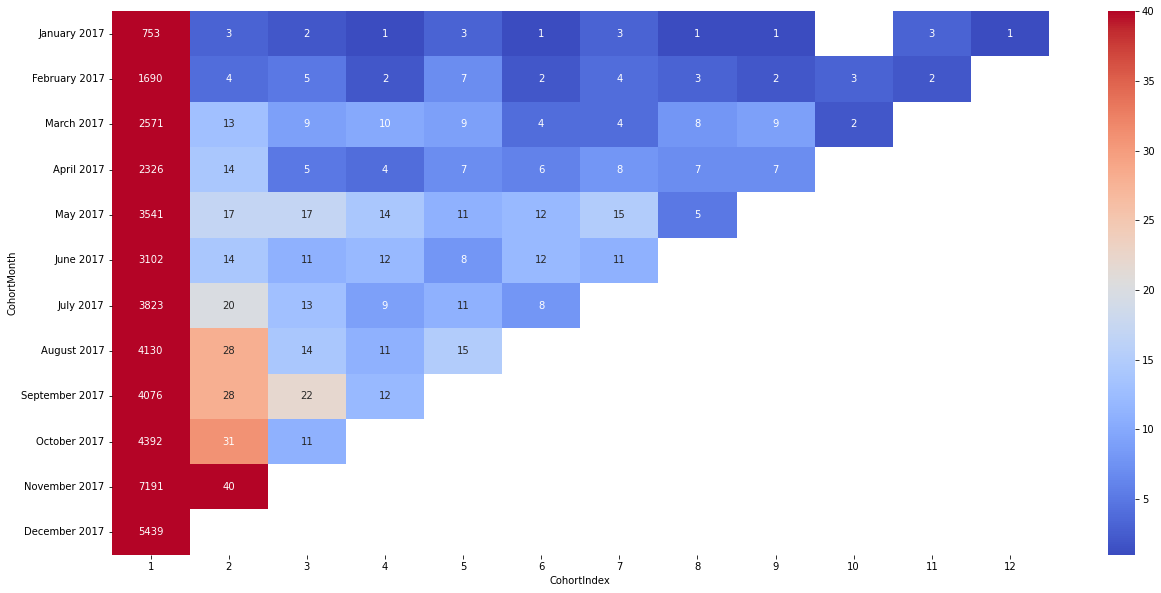

In [69]:
# Визуализируем retention в абсолютных значениях
plt.figure(figsize=(21, 10))
sns.heatmap(retention, annot=True, cmap='coolwarm', fmt='g', vmax=40)

In [70]:
# Преобразуем таблицу retention в относительные значения
retention_percent = retention.divide(retention.iloc[:, 0], axis=0)
retention_percent

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,
January 2017,1.0,0.003984,0.002656,0.001328,0.003984,0.001328,0.003984,0.001328,0.001328,NaN,0.003984,0.001328
February 2017,1.0,0.002367,0.002959,0.001183,0.004142,0.001183,0.002367,0.001775,0.001183,0.001775,0.001183,NaN
March 2017,1.0,0.005056,0.003501,0.003890,0.003501,0.001556,0.001556,0.003112,0.003501,0.000778,NaN,NaN
April 2017,1.0,0.006019,0.002150,0.001720,0.003009,0.002580,0.003439,0.003009,0.003009,NaN,NaN,NaN
May 2017,1.0,0.004801,0.004801,0.003954,0.003106,0.003389,0.004236,0.001412,NaN,NaN,NaN,NaN
June 2017,1.0,0.004513,0.003546,0.003868,0.002579,0.003868,0.003546,NaN,NaN,NaN,NaN,NaN
July 2017,1.0,0.005231,0.003400,0.002354,0.002877,0.002093,NaN,NaN,NaN,NaN,NaN,NaN
August 2017,1.0,0.006780,0.003390,0.002663,0.003632,NaN,NaN,NaN,NaN,NaN,NaN,NaN
September 2017,1.0,0.006869,0.005397,0.002944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='CohortIndex', ylabel='CohortMonth'>

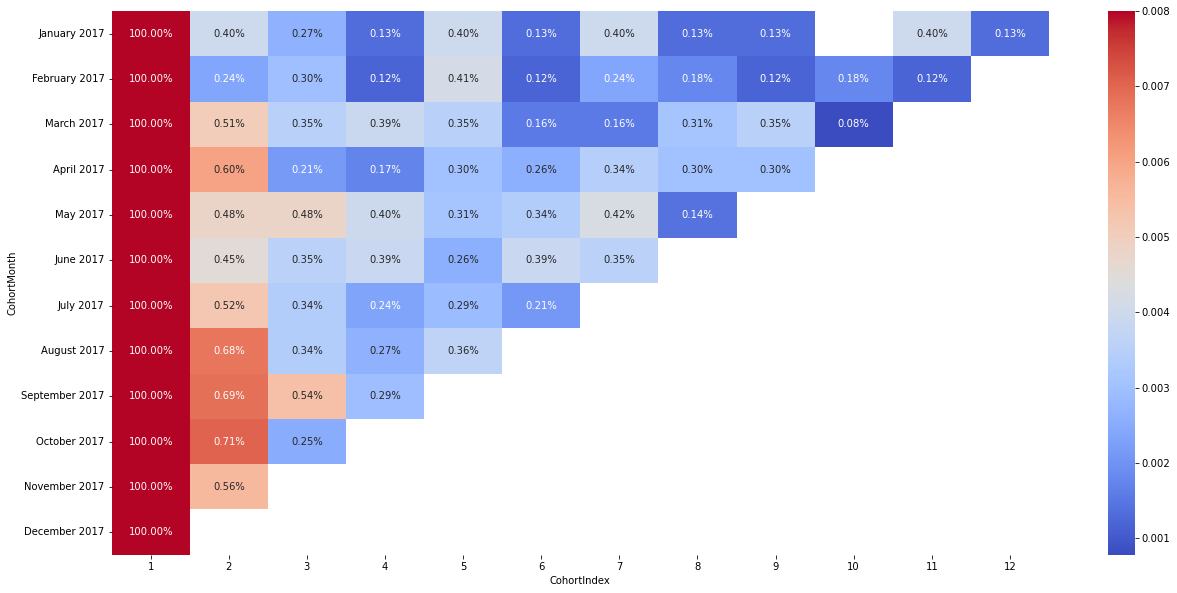

In [71]:
# Визуализируем retention в процентах
plt.figure(figsize=(21, 10))
sns.heatmap(retention_percent, annot=True, cmap='coolwarm', fmt='.2%', vmax=0.008)

**Когорта за май имеет самый высокий retention на 3й месяц(CohortIndex 4) в 2017 году-0.415867%**

# 6. RFM-сегментация пользователей, для качественной оценки аудитории

**6.1.Подготовка данных за 2 года о:** 
* **Recency(R) - времени от последней покупки до текущей даты , частоте и сумме покупок за 2 года.**
* **Frequency(F) -  суммарном количестве покупок у пользователя за всё время**
* **Monetary(M) - сумме покупок за всё время**

In [72]:
customer_data.head()

,customer_unique_id,order_purchase_timestamp
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39


Чтобы определить время от последней покупки пользователя до текущей даты, предположим, что данные были получены на следующий
день после их формирования. Последняя дата в базе совершенных покупок 3 сентября 2018 года

In [73]:
print(customer_data['order_purchase_timestamp'].max())
print(customer_data['order_purchase_timestamp'].min())

2018-09-03 09:06:57
2016-09-04 21:15:19


Определили день для отсчета разницы в днях, как последнюю дату, указанную в базе плюс один день

In [74]:
day_of_report = (customer_data['order_purchase_timestamp'].max() + pd.DateOffset(days=1))
print(day_of_report)

2018-09-04 09:06:57


Посчитали разницу в днях между предполагаемой текущей датой и датой совершенных заказов

In [75]:
customer_data["days_diff"] = (day_of_report - customer_data["order_purchase_timestamp"]).dt.days
customer_data.head()

,customer_unique_id,order_purchase_timestamp,days_diff
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,336
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,41
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,27
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,289
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,202


По каждому покупателю определили, сколько дней тому назад он в последний раз совершал покупку (recency). Т.е. количество дней между последней совершенной покупкой и текущим днем должна быть минимальная

In [76]:
recency = customer_data.groupby('customer_unique_id', as_index=False)['days_diff'].min()
recency.head()

,customer_unique_id,days_diff
0,0000366f3b9a7992bf8c76cfdf3221e2,116
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119
2,0000f46a3911fa3c0805444483337064,542
3,0000f6ccb0745a6a4b88665a16c9f078,326
4,0004aac84e0df4da2b147fca70cf8255,293


Суммарное количество покупок у пользователя за всё время (frequency) было посчитано в первом пункте

In [77]:
frequency = sum_of_orders
frequency.head()

,customer_unique_id,sum_of_orders
52358,8d50f5eadf50201ccdcedfb9e2ac8455,16
23201,3e43e6105506432c953e165fb2acf44c,9
37374,6469f99c1f9dfae7733b25662e7f1782,7
10235,1b6c7548a2a1f9037c1fd3ddfed95f33,7
75211,ca77025e7201e3b30c44b472ff346268,7


Чтобы посчитать сумму покупок каждого покупателя за всё время (monetary) сначала определим сумму каждого заказа в таблице `items`, а затем суммируем стоимость всех заказов для каждого уникального покупателя

In [78]:
revenue_per_order = items.groupby('order_id', as_index=False)['price'].sum()

In [79]:
# присоединили к заказам и покупателям сумму заказа
data_m = order_customer_data.merge(revenue_per_order[['price', 'order_id']], on='order_id', how='left')

In [80]:
# Опеределили сумму покупок каждого покупателя за всё время (monetary)
revenue_customers = data_m.groupby('customer_unique_id', as_index=False)\
    .agg({'price': 'sum'})\
    .rename(columns={'price': 'total_customer_revenue'})\
    .sort_values(by='total_customer_revenue', ascending=False)
# monetary
monetary = revenue_customers
monetary.head()

,customer_unique_id,total_customer_revenue
3788,0a0a92112bd4c708ca5fde585afaa872,13440.0
81017,da122df9eeddfedc1dc1f5349a1a690c,7388.0
43943,763c8b1c9c68a0229c42c9fc6f662b93,7160.0
81856,dc4802a71eae9be1dd28f5d788ceb526,6735.0
25904,459bef486812aa25204be022145caa62,6729.0


Объединили 3 метрики: recency, frequency, monetary в один датафрейм

In [81]:
rfm_data = pd.concat([recency, frequency['sum_of_orders'], monetary['total_customer_revenue']], axis=1)
rfm_data.columns = ['customer_unique_id', 'recency', 'frequency', 'monetary']
rfm_data.head()

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90
2,0000f46a3911fa3c0805444483337064,542,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00


**6.2. Определение границ метрик**

In [82]:
# Описательная статистика метрик
rfm_data.describe()

,recency,frequency,monetary
count,94990.000000,94990.000000,94990.000000
mean,243.448374,1.033867,142.061277
std,152.999947,0.210826,216.070479
min,1.000000,1.000000,0.000000
25%,119.000000,1.000000,47.882500
50%,224.000000,1.000000,89.810000
75%,352.000000,1.000000,155.000000
max,729.000000,16.000000,13440.000000


***Recency***

Определим границы recency:
Исходя из округленных данных процентилей 25, 50 и 75 % 
* 1-покупали давно-более 300 дней
* 2-покупали относительно недавно- от 120 до 300 дней
* 3-покупали недавно-от 1 до 120 дней

<AxesSubplot:xlabel='recency', ylabel='Density'>

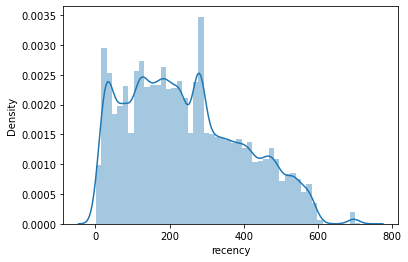

In [83]:
sns.distplot(rfm_data['recency'])

Примерно после 300 дней идет спад количества пользователей

In [84]:
def recency_score(rec):
    '''функция для присвоения показателя recency'''
    if rec <= 120:
        return 1
    elif (rec > 120) and (rec <= 300):
        return 2
    else:
        return 3


rfm_data['R'] = rfm_data['recency'].apply(recency_score)

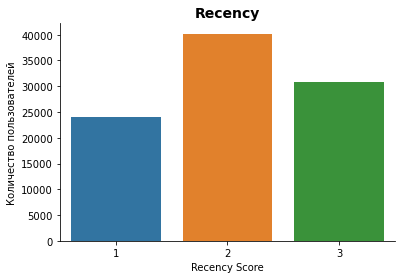

In [85]:
ax = sns.countplot(rfm_data['R'])
ax.set_title('Recency', fontsize=14, fontweight='bold')
ax.set_xlabel('Recency Score')
ax.set_ylabel('Количество пользователей')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

Основное количество пользователей пришло на сайт относительно недавно

***Frequency***

Из 96096 покупателя: 92102 совершили только 1 покупку, что состаялвяет почти 96% 

In [86]:
# Рассмотрим сколько покупателей сделали определенное количество покупок
rfm_data.query('frequency>1')['frequency'].value_counts()

2     2652
3     188 
4     29  
5     9   
6     5   
7     3   
9     1   
16    1   
Name: frequency, dtype: int64

Покупатели делали 1,2,3,4,5,6,7,9,16 покупок. Из них 5 покупок-медианное значение. Исходя из этого установим следующие границы для frequency :
* 1-покупали редко или однократно-1,2 покупок
* 2-покупали несколько раз-3-5 покупок
* 3-покупали часто-более 5 раз

In [87]:
def frequency_score(freq):
    '''функция для присвоения показателя frequency'''
    if freq <= 2:
        return 1
    elif (freq > 2) and (freq <= 5):
        return 2
    else:
        return 3


rfm_data['F'] = rfm_data['frequency'].apply(frequency_score)

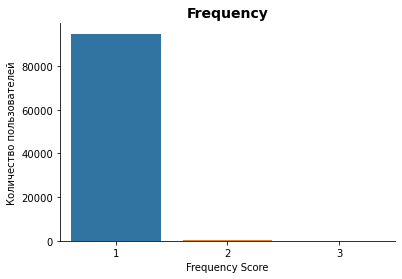

In [88]:
ax = sns.countplot(rfm_data['F'])
ax.set_title('Frequency', fontsize=14, fontweight='bold')
ax.set_xlabel('Frequency Score')
ax.set_ylabel('Количество пользователей')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

На графике видно, что почти все пользователи делали покупки редко или однократно

***Monetary***

<AxesSubplot:xlabel='monetary', ylabel='Density'>

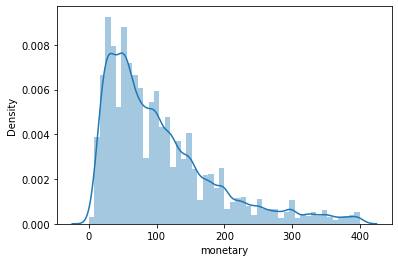

In [89]:
plt.ticklabel_format(style='plain')
sns.distplot(rfm_data[rfm_data['monetary'] < 400]['monetary'])

Маскимальное значение по monetary 13440, однако по графику видно,что основная часть покупателей совершали покупки в пределах 100. После 100 сумма идет на спад

Для monetary установим следующие границы:
* 1-маленькая сумма заказа- менее 100
* 2-средняя сумма заказа -от 100 до 300
* 3-большая сумма заказа- более 300

In [90]:
def monetary_score(mon):
    '''функция для присвоения показателя monetary'''
    if mon <= 100:
        return 1
    elif (mon > 100) and (mon <= 300):
        return 2
    else:
        return 3


rfm_data['M'] = rfm_data['monetary'].apply(monetary_score)

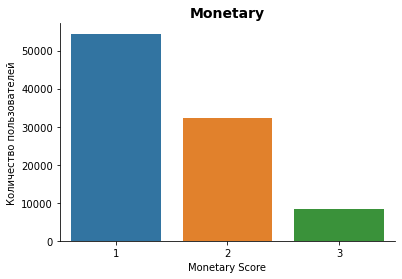

In [91]:
ax = sns.countplot(rfm_data['M'])
ax.set_title('Monetary', fontsize=14, fontweight='bold')
ax.set_xlabel('Monetary Score')
ax.set_ylabel('Количество пользователей')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

На графике видна обратная зависимость количества покупателей и потраченной суммы. Чем выше сумма тем меньше покупателей

In [92]:
# Проставим RFM Score каждому покупателю
rfm_data['RFM Score'] = rfm_data.apply(lambda x: str(x['R']) + str(x['F']) + str(x['M']), axis=1)
rfm_data.head()

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM Score
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,1,1,2,112
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,1,1,1,111
2,0000f46a3911fa3c0805444483337064,542,1,69.00,3,1,1,311
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,3,1,1,311
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,2,1,2,212


In [93]:
# количество полученных комбинаций RFM Score
rfm_data['RFM Score'].nunique()

21

In [94]:
rfm_data['RFM Score'].value_counts()

211    22838
311    18110
212    13931
111    13475
312    9907 
112    8377 
213    3323 
313    2743 
113    2050 
123    45   
222    44   
223    44   
322    26   
323    25   
122    24   
321    9    
121    6    
133    5    
233    4    
221    3    
331    1    
Name: RFM Score, dtype: int64

**6.3. Определение сегментов:** 
* ПОТЕРЯННЫЕ - 11Х покупатели, которые давно сделали одну покупку, скорее всего уже не вернутся
* УШЕДШИЕ - 12Х и 13Х покупатели, которые в прошлом были активны, но потом ушли
* ТРЕБУЮТ ВНИМАНИЕ - 21X сделали одну покупку относительно недавно, могут уйти, а могут стать перспективными 
* ПЕРСПЕКТИВНЫЕ - 22Х, 23Х покупатели, которые совершили покупку относительно недавно, на сумму выше минимальной, у них есть потенциал стать лояльными
* НОВЫЕ - 311 новые покупатели, недавно совершили одну покупку на минимальную сумму
* МНОГООБЕЩАЮЩИЕ - 312, 313 новые покупатели которые недавно сделали покупку на сумму выше минимальной
* ЛОЯЛЬНЫЕ - 32Х, 33Х покупатели, у которых последняя покупка была недавно, покупали относительно часто 


In [95]:
# Создали колонку с названием сегмента для каждого пользователя
segt_map = {
    r'[1][1][1-3]': 'потерянные',
    r'[1][2-3][1-3]': 'ушедшие',
    r'[2][1][1-3]': 'требуют внимания',
    r'[2][2-3][1-3]': 'перспективные',
    r'[3][1][1]': 'новые',
    r'[3][1][2-3]': 'многообещающие',
    r'[3][2-3][1-3]': 'лояльные'
    }
rfm_data['Segment'] = rfm_data['R'].map(str) + rfm_data['F'].map(str) + rfm_data['M'].map(str)
rfm_data['Segment'] = rfm_data['Segment'].replace(segt_map, regex=True)
rfm_data.head()

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM Score,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,1,1,2,112,потерянные
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,1,1,1,111,потерянные
2,0000f46a3911fa3c0805444483337064,542,1,69.00,3,1,1,311,новые
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,3,1,1,311,новые
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,2,1,2,212,требуют внимания


In [96]:
# Количество пользователей по сегментам
rfm_data['Segment'].value_counts()

требуют внимания    40092
потерянные          23902
новые               18110
многообещающие      12650
перспективные       95   
ушедшие             80   
лояльные            61   
Name: Segment, dtype: int64

[Text(0, 0, '40092 (42.207%)'),
 Text(0, 0, '23902 (25.163%)'),
 Text(0, 0, '18110 (19.065%)'),
 Text(0, 0, '12650 (13.317%)'),
 Text(0, 0, '95 (0.100%)'),
 Text(0, 0, '80 (0.084%)'),
 Text(0, 0, '61 (0.064%)')]

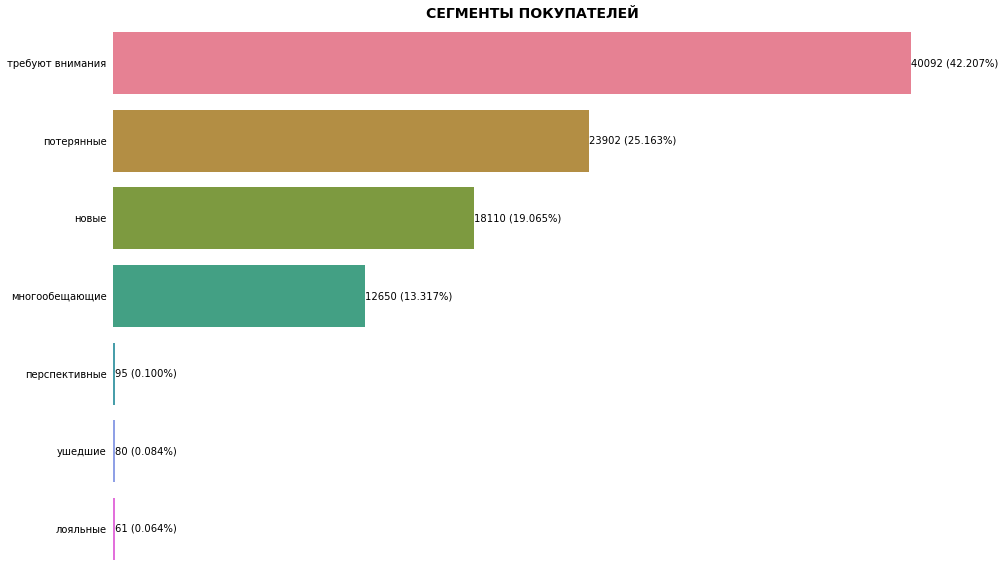

In [97]:
# Визуализация количества пользователей по сегментам
plt.figure(figsize=(15, 10))
ax = sns.countplot(y=rfm_data['Segment'], order=rfm_data['Segment'].value_counts(ascending=False).index, palette="husl")
ax.set_title('СЕГМЕНТЫ ПОКУПАТЕЛЕЙ', fontsize=14, fontweight='bold')
ax.set_xlabel(None)
ax.set_ylabel(None)

ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)

abs_values = rfm_data['Segment'].value_counts(ascending=False)
rel_values = rfm_data['Segment'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.3f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)

`Лояльных` как и `ушедших` покупателей меньше одного процента. Основную массу покупателей составляют сегменты, которые делали покупку недавно или относительно недавно.
* 42% составляют покупатели, которые сделали относительно недано одну покупку, у них есть потенциал попасть как в группу ушедших, так и в группу лояльных. На данном этапе эта группа покупателей `требует внимания`. 
* `Потерянные` на данный момент покупатели, которые в прошлом делали несколько покупок составляют 25 процентов. Это второй по величине сегмент, требуется найти возможность его уменьшить и вернуть внимание этих покупателей к продукту.
* Довольно большой процент `новых` покупателей, 19% покупателей недавно сделали только одну покупку и присматриваются к продукту, а 13% недавно сделали несколько покупок, что показывает заинтересованность в продукте, эти покупатели опали в сегмент `многообещающие`.    